In [1]:
import pandas as pd, numpy as np, holidays, seaborn as sns, matplotlib.pyplot as plt, time, xgboost as xgb, json, pickle
from sqlalchemy import create_engine
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import metrics

from config import config

In [2]:
script_start=time.time()

<h2>Data Collection</h2>

In [3]:
#establish connection to db and retrieve data
config=config()
engine=create_engine("postgresql://"+config["user"]+":"+config["password"]+"@"+config["host"]+"/"+config["database"])
line='15A'
direction=1
sql=("SELECT lt.daystamp, lt.progr_number, lt.stoppoint_id,lt.arrival_time_p,lt.arrival_time_a,"
    "lt.departure_time_p,lt.departure_time_a,trips.route_id,"
     "trips.arrival_time_p,trips.departure_time_p,trips.departure_time_a,"
     "weather_main,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_description "
     "FROM leavetimes AS lt, trips, weather "
     "WHERE trips.line_id='"+line+"' AND trips.direction="+str(direction)+" AND trips.suppressed=0 "
     "AND lt.daystamp = trips.daystamp AND lt.trip_id = trips.trip_id AND lt.suppressed=0"
     "AND lt.weather_id = weather.daytime")
df = pd.read_sql(sql,engine)

In [4]:
#renames the features of the dataframe
features=list(df.columns)
features[0]="daystamp"
features[2]="stop_id"
features[3]="arr_p"
features[4]="arr_a"
features[5]="dep_p"
features[6]="dep_a"
features[8]="end_p"
features[9]="start_p"
features[10]="start_a"
df.columns=features

In [5]:
holidays_IE=holidays.Ireland()
def daystamp_converter(time):
    """extracts and returns tuple of (weekday,month,hour,holiday) from datetime object."""
    date=datetime.fromtimestamp(time)
    if date in holidays_IE:
        holiday=1
    else:
        holiday=0
    return (date.weekday(),date.month,date.hour,holiday)

In [6]:
#convert time specific data from the dataframe
df["dt"]=df.daystamp.values+df.dep_p.values
df["weekday"],df["month"],df["hour"],df["holiday"]=zip(*df['dt'].apply(daystamp_converter))
df["dur_s"]=df.dep_p.values-df.start_p.values
df["dur_a"]=df.dep_a.values-df.start_a.values

<h2>Feature Cleaning</h2>

In [7]:
#create log dict
logs={
    "rows":{
        "start":df.shape[0]
    }
}

In [8]:
#filter out uncommon routes
routes=df.route_id.value_counts().index[0]
df_clean=df[df.route_id==routes]
rows_routes=df_clean.shape[0]
logs["rows"]["route_filter"]=rows_routes-logs["rows"]["start"]

In [9]:
#remove null values
df_clean = df_clean.dropna(axis = 0, how ='any') 
rows_after_nan=df_clean.shape[0]
logs["rows"]["nan_filter"]=rows_after_nan-rows_routes

In [10]:
#calculate ratio of least to most visited stop
stop_counts=df_clean.stop_id.value_counts()
logs["scr"]=min(stop_counts)/max(stop_counts)

In [11]:
#assign features to type
categorical=["stop_id","route_id","weather_main","weather_description","weekday","month","hour","holiday"]
df_clean[categorical]=df_clean[categorical].astype("category")
ints=['daystamp','progr_number','arr_p','arr_a','dep_p','dep_a','dur_s','dur_a','pressure','humidity','wind_deg','clouds_all']
floats=['temp','feels_like','temp_min','temp_max','wind_speed']

In [12]:
#clean up dataframe
df_clean=df_clean.drop(["route_id"],axis=1)
df_clean[ints]=df_clean[ints].astype('int64')
df_clean=df_clean[df_clean.dur_a>=0]
rows_after_dur=df_clean.shape[0]
logs["rows"]["negative_dur"]=rows_after_dur-rows_after_nan
df_clean=df_clean.drop(["stop_id"],axis=1)

In [13]:
#create dataframe with means and standard deviations per progr_number
dur_stats_df=pd.DataFrame(columns=["progr_number","dur_mean","dur_std"])
for progr_number in df_clean.progr_number.unique():
    durations=df_clean.dur_a[df_clean["progr_number"]==progr_number]
    dur_stats_df=dur_stats_df.append(pd.Series([progr_number,durations.mean(),durations.std()],index=dur_stats_df.columns),ignore_index=True)
    dur_stats_df["progr_number"]=dur_stats_df["progr_number"].astype('int64')

#merge duration stats with df_clean and look for outliers (outside 3 SDs from mean)
df_clean=df_clean.merge(dur_stats_df,how='inner',on='progr_number')
df_clean["outlier"]=abs(df_clean["dur_a"]-df_clean["dur_mean"])>3*df_clean["dur_std"]

#only keep rows that aren't outliers
df_clean=df_clean[df_clean["outlier"]==False]
rows_after_outliers=df_clean.shape[0]
logs["rows"]["outliers"]=rows_after_outliers-rows_after_dur
logs["rows"]["end"]=rows_after_outliers
#remove stat columns from dataframe
df_clean=df_clean.drop(["dur_mean","dur_std","outlier"],axis=1)

In [14]:
#add statistics of means and std to logs
logs["stats"]=dur_stats_df.set_index("progr_number").to_dict("index")

<h2>Feature Selection</h2>

In [15]:
#determine best feature combinations
y=df_clean["dur_a"]
X=df_clean.drop(["dur_a"],axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)
categorical=X_train.columns[X_train.dtypes=="category"]
X_train_enc=pd.get_dummies(X_train[categorical],drop_first=True)
X_test_enc=pd.get_dummies(X_test[categorical],drop_first=True)
dummy_columns=list(X_train_enc.columns)
#calculate f-regression values
fs=SelectKBest(score_func=f_regression, k='all')
fs.fit(X_train_enc,y_train)
X_train_fs=fs.transform(X_train_enc)
X_test_fs=fs.transform(X_test_enc)

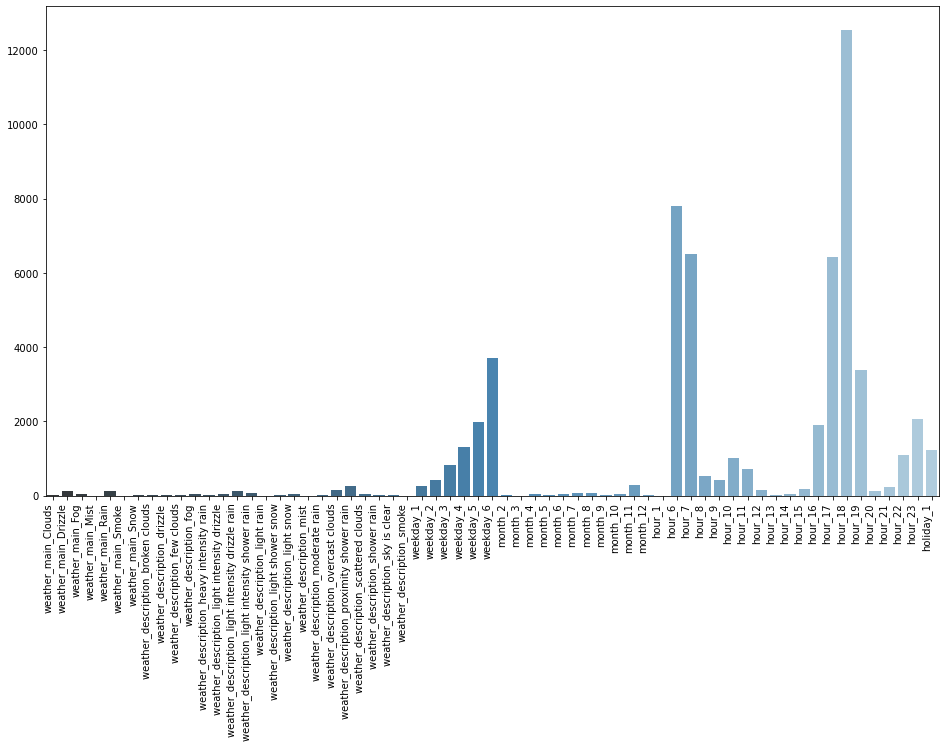

In [16]:
plt.figure(figsize=(16,9))
ax = sns.barplot(x=dummy_columns, y=fs.scores_,palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.savefig("img/"+line+"_"+str(direction)+"_cat.png")

In [20]:
f_values={}
for column,f_value in zip(dummy_columns,fs.scores_):
    f_values[column]=f_value
logs["feature_eval"]={
    "f_values":f_values
}

In [22]:
#calculate correlation for numerical features
numeric=X_train.columns[(X_train.dtypes=="int64") | (X_train.dtypes=="float64")]
corr=pd.concat([X_train[numeric], y], axis=1).corr()

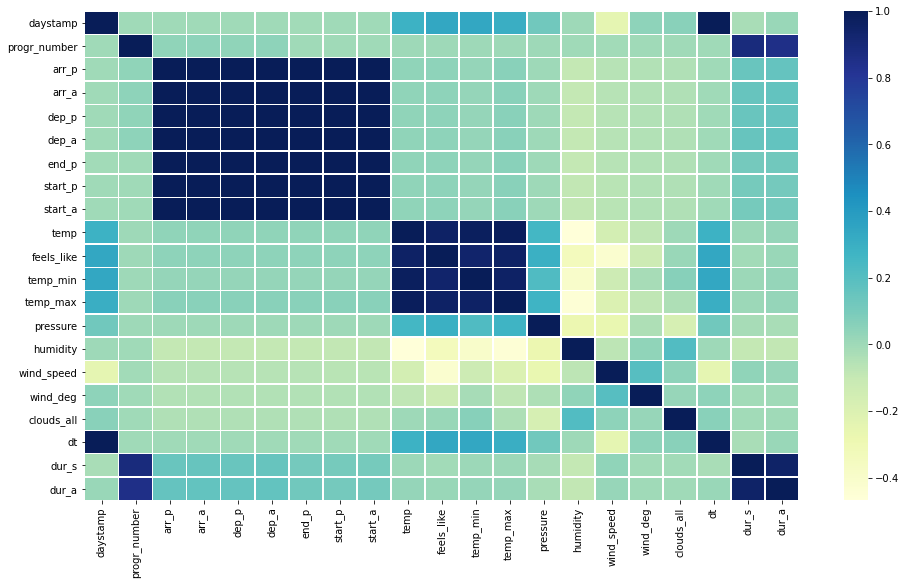

In [23]:
plt.figure(figsize=(16,9))
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidth=.5,cmap="YlGnBu")
plt.savefig("img/"+line+"_"+str(direction)+"_num.png")

In [26]:
cors=corr.dur_a.drop(["dur_a"]).to_dict()
logs["feature_eval"]["correlations"]=cors

In [27]:
logs["feature_eval"]

{'f_values': {'weather_main_Clouds': 1.95835894714687,
  'weather_main_Drizzle': 130.36380550483878,
  'weather_main_Fog': 29.65847935263489,
  'weather_main_Mist': 0.8180839153421375,
  'weather_main_Rain': 114.14453281042749,
  'weather_main_Smoke': 0.3453586745937708,
  'weather_main_Snow': 26.392923930867354,
  'weather_description_broken clouds': 6.7416286729691555,
  'weather_description_drizzle': 15.076956607563163,
  'weather_description_few clouds': 16.951022338598168,
  'weather_description_fog': 29.65847935263489,
  'weather_description_heavy intensity rain': 26.85391866989347,
  'weather_description_light intensity drizzle': 29.53675785293617,
  'weather_description_light intensity drizzle rain': 127.37678691852821,
  'weather_description_light intensity shower rain': 58.274570703144775,
  'weather_description_light rain': 1.0207522002897713,
  'weather_description_light shower snow': 3.935796138748062,
  'weather_description_light snow': 38.66259421051114,
  'weather_descr

In [30]:
high_corr=corr["dur_a"][(corr["dur_a"]>=0.5) | (corr["dur_a"]<=-0.5)]
high_corr

progr_number    0.855439
dur_s           0.951120
dur_a           1.000000
Name: dur_a, dtype: float64

In [31]:
#assemble dataframe for modelling
numeric=["progr_number","dur_s","humidity"]
X=pd.concat([pd.get_dummies(X[categorical].drop(["weather_main"],axis=1),drop_first=True),df_clean[numeric]],axis=1)
y=df_clean["dur_a"]
X=X.reset_index(drop=True)
y=y.reset_index(drop=True)

<h2>Modelling</h2>

In [32]:
#split data
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1)
#set up and train model
xgb_reg=xgb.XGBRegressor(learning_rate=0.3, max_depth=5, n_estimators=200)
start=time.time()
xgb_reg.fit(X_train,y_train)
wall_time=time.time()-start
wall_time
#store model performance
mse=metrics.mean_squared_error(y_pred=xgb_reg.predict(X_test), y_true=y_test)
logs["modelling"]={
    "XGBoost":{
        "time":wall_time,
        "r_2":metrics.r2_score(y_pred=xgb_reg.predict(X_test), y_true=y_test),
        "mse":mse,
        "rmse":mse**(1/2),
        "mae":metrics.mean_absolute_error(y_pred=xgb_reg.predict(X_test), y_true=y_test)   
    }    
}
#store model benchmarks
mse=metrics.mean_squared_error(y_pred=X_test.dur_s, y_true=y_test)
logs["modelling"]["Benchmark"]={
    "r_2":metrics.r2_score(y_pred=X_test.dur_s, y_true=y_test),
    "mse":mse,
    "rmse":mse**(1/2),
    "mae":metrics.mean_absolute_error(y_pred=X_test.dur_s, y_true=y_test)
}
#store model features
logs["features"]=list(X.columns)
#write logs
with open("logs/"+line+"_"+str(direction)+".json", "w") as outfile: 
    outfile.write(json.dumps(logs,indent = 4)) 
#dump model
with open ("pickle/"+line+"_"+str(direction)+".sav", "wb") as pickle_file:
    pickle.dump(xgb_reg,pickle_file)